In [ ]:
!git clone https://github.com/Bduz/intro_pytorch.git

fatal: destination path 'intro_pytorch' already exists and is not an empty directory.


# 0 - Load all the Necessary Modules

In [ ]:
import sys
sys.path.insert(0, '/content/intro_pytorch/')

In [ ]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import helperfuncs

# 1 - Load and Process the Data

Load the MNIST data and transform it.

In [ ]:
from torchvision import datasets, transforms

# Define transformations on the data
transform  = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5)),])

#Load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

#Load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# 2 - The Model of the Neural Network

Let's use the [LeNet](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) model as our ConvNet.

In [ ]:
class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    # 1 input image channel, 6 output channels, 5x5 square convolution
    # kernel
    self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
      # Max pooling over a (2, 2) window
      x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
      # If the size is a square, you can specify with a single number
      x = F.max_pool2d(F.relu(self.conv2(x)), 2)
      x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x


model = MnistModel()
model


MnistModel(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# 3 - Train the Model

In [ ]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 5
print_every = 40
steps = 0
for e in range(epochs):
  running_loss = 0
  for images, labels in iter(trainloader):
    steps += 1

    optimizer.zero_grad()

    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if steps % print_every == 0:
      # Make sure network is in eval mode for inference
      model.eval()
      
      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():
          test_loss, accuracy = validation(model, testloader, criterion)
          
      print("Epoch: {}/{}.. ".format(e+1, epochs),
            "Training Loss: {:.3f}.. ".format(running_loss/print_every),
            "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
            "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
      
      running_loss = 0
      
      # Make sure training is back on
      model.train()


Epoch: 1/10..  Training Loss: 2.214..  Test Loss: 2.193..  Test Accuracy: 0.397
Epoch: 1/10..  Training Loss: 2.168..  Test Loss: 2.133..  Test Accuracy: 0.385
Epoch: 1/10..  Training Loss: 2.097..  Test Loss: 2.024..  Test Accuracy: 0.391
Epoch: 1/10..  Training Loss: 1.926..  Test Loss: 1.814..  Test Accuracy: 0.402
Epoch: 1/10..  Training Loss: 1.681..  Test Loss: 1.517..  Test Accuracy: 0.568
Epoch: 1/10..  Training Loss: 1.371..  Test Loss: 1.231..  Test Accuracy: 0.665
Epoch: 1/10..  Training Loss: 1.114..  Test Loss: 1.008..  Test Accuracy: 0.690
Epoch: 1/10..  Training Loss: 0.888..  Test Loss: 0.782..  Test Accuracy: 0.765
Epoch: 1/10..  Training Loss: 0.736..  Test Loss: 0.697..  Test Accuracy: 0.780
Epoch: 1/10..  Training Loss: 0.637..  Test Loss: 0.608..  Test Accuracy: 0.810
Epoch: 1/10..  Training Loss: 0.602..  Test Loss: 0.501..  Test Accuracy: 0.847
Epoch: 1/10..  Training Loss: 0.531..  Test Loss: 0.475..  Test Accuracy: 0.854
Epoch: 1/10..  Training Loss: 0.502..  T

# 4 - Analyze the Results

In [ ]:
images, labels = next(iter(testloader))

with torch.no_grad():
  logits = model.forward(images)

ps = F.softmax(logits, dim=1)

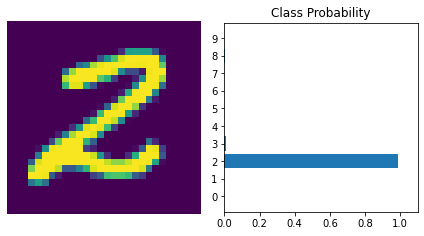

In [ ]:
index = 20
helperfuncs.view_classify(images[index], ps[index])